In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers tokenizers
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from typing import List
import logging
import copy
import os
import sys
import gc
import random
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:

_CITATION = '''
@inproceedings{rashkin2019towards,
  title = {Towards Empathetic Open-domain Conversation Models: a New Benchmark and Dataset},
  author = {Hannah Rashkin and Eric Michael Smith and Margaret Li and Y-Lan Boureau},
  booktitle = {ACL},
  year = {2019},
}
'''

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_train_equal.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_test_equal.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_val_equal.txt"

In [ ]:
labels = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy"]
label2int = dict(zip(labels, list(range(len(labels)))))

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

###Now we can start building a classifier

In [ ]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
model = AutoModelWithLMHead.from_pretrained('roberta-base')
base_model = model.base_model

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [ ]:
#define an EmoClassificationModel class to do the actual fine-tuning

class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

In [ ]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

!mkdir -p tokenizer

tokenizer.save_pretrained("tokenizer")

!ls tokenizer

In [ ]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512): 

        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels)) 
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), '/content/RoBERTa_finetuned_emp_dia.pt')

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2,
    seed=21
)
module = TrainingModule(hparams)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
module.save_model()

##Evaluation on the held-out test

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

-
________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.7188    0.6970    0.7077        66
           joy     0.8209    0.8333    0.8271        66
         anger     0.7736    0.6212    0.6891        66
          fear     0.7500    0.8636    0.8028        66
          love     0.7467    0.8485    0.7943        66
   instability     0.8030    0.8030    0.8030        66
       disgust     0.7945    0.8788    0.8345        66
disappointment     0.6986    0.7727    0.7338        66
         shame     0.7500    0.6818    0.7143        66
         guilt     0.7391    0.7727    0.7556        66
          envy     0.9600    0.7273    0.8276        66

      accuracy                         0.7727       726
     macro avg     0.7777    0.7727    0.7718       726
  weighted avg     0.7777    0.7727    0.7718       726



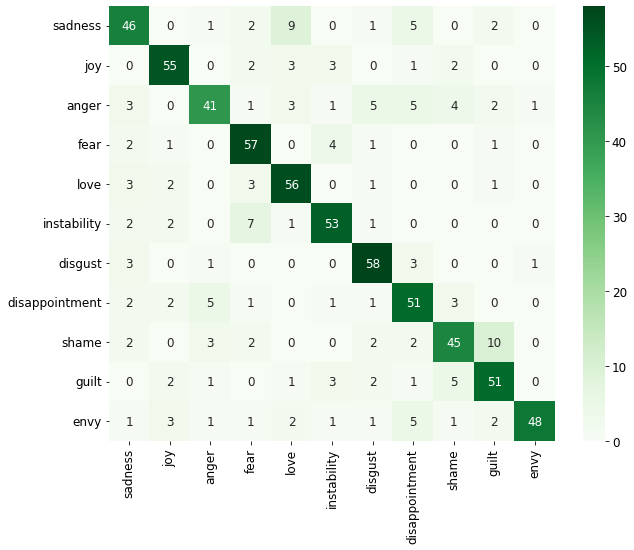

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');

## Fine tune on our data

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_train_equal_no_jealous.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_test_equal_no_jealous.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_val_equal_no_jealous.txt"

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams, model):
        super().__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW 
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), '/content/RoBERTa_double_finetuned_emp_dia.pt')

In [ ]:
model = EmoClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels))
device = torch.device('cuda:0')
model.load_state_dict(torch.load('/content/RoBERTa_finetuned_emp_dia.pt'))
model.to(device)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


EmoClassificationModel(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2
)
module = TrainingModule(hparams, model)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | EmoClassificationModel | 124 M 
1 | los

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
module.save_model()

##Evaluation on the held-out test

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))


________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.8571    0.8182    0.8372        22
           joy     0.9444    0.8095    0.8718        21
         anger     0.8636    0.9048    0.8837        21
          fear     0.9600    0.9231    0.9412        26
          love     0.8519    0.9200    0.8846        25
   instability     0.8276    0.9231    0.8727        26
       disgust     0.9130    0.8750    0.8936        24
disappointment     0.9062    0.9355    0.9206        31
         shame     0.9545    0.9545    0.9545        22
         guilt     1.0000    0.9444    0.9714        18
          envy     1.0000    1.0000    1.0000        27

      accuracy                         0.9125       263
     macro avg     0.9162    0.9098    0.9120       263
  weighted avg     0.9149    0.9125    0.9127       263



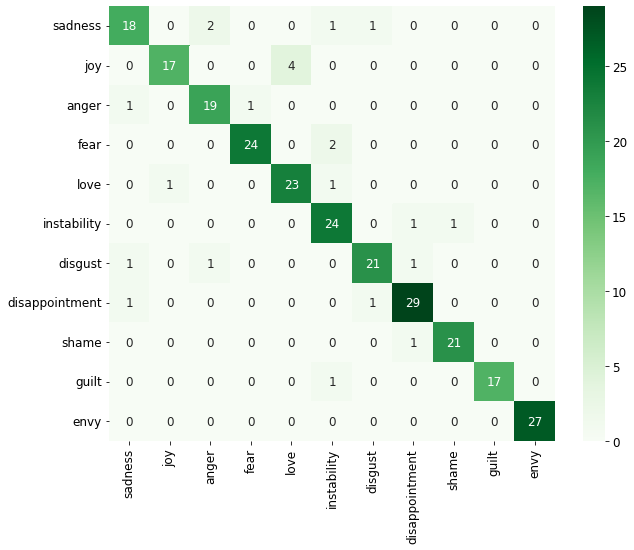

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');